In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
import matplotlib.pyplot as plt 
%matplotlib inline 


In [2]:
imagesDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\image"
masksDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\label"
images = sorted(
    [
        os.path.join(imagesDir, fname)
        for fname in os.listdir(imagesDir)
        if fname.endswith(".tif")
    ]
)
masks = sorted(
    [
        os.path.join(masksDir, fname)
        for fname in os.listdir(masksDir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

In [3]:
im_width = 256
im_height = 256
border = 5

X = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)



In [4]:
from skimage.transform import resize
for n, id_ in enumerate(images):
    img_path = images[n]
    img = keras.utils.load_img(img_path, color_mode = "grayscale")
    x_img = keras.utils.img_to_array(img)
    x_img = resize(x_img, (256,256, 1), mode = 'constant', preserve_range = True)
    X[n] = x_img/255.0
   



In [5]:
for n, id in enumerate(masks):
    mask_path = masks[n]
    mask = keras.utils.img_to_array(keras.utils.load_img(mask_path, color_mode = "grayscale"))
    mask = resize(mask, (256,256, 1), mode = 'constant', preserve_range = True)
    y[n] = mask/255.0
    
print(X.size)
print(y.size)

16449536
16449536


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


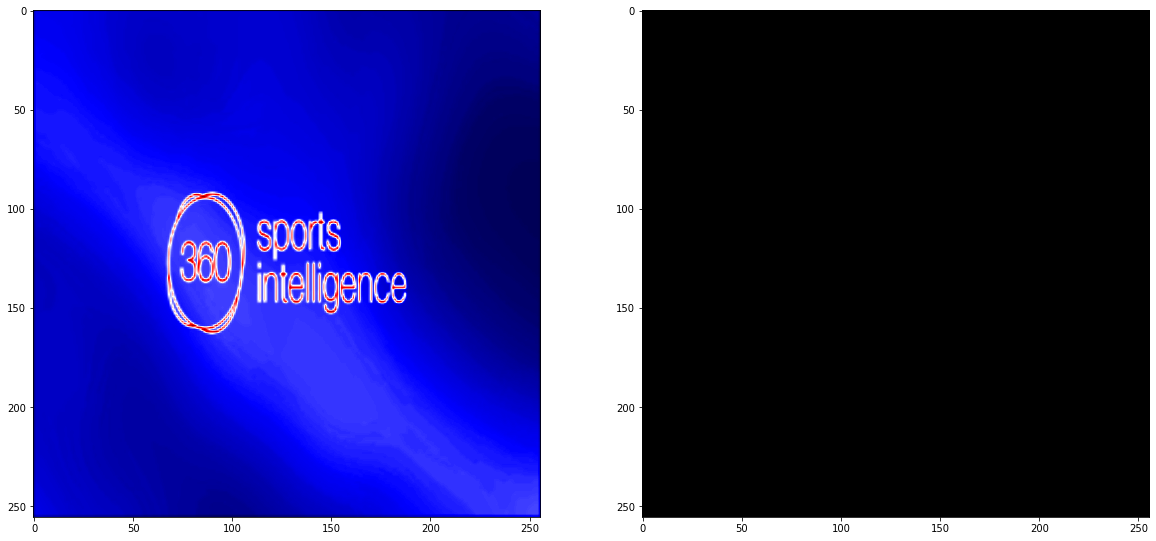

In [14]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: 
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')


In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    EarlyStopping(monitor='loss', patience=3)
]

In [18]:
results = model.fit(X_train, y_train, batch_size=32, epochs=5, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/5
8/8 [==============================] - 38s 5s/step - loss: 1.0098 - accuracy: 0.2527 - val_loss: 0.5748 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 2/5
8/8 [==============================] - 38s 5s/step - loss: 0.6334 - accuracy: 0.5693 - val_loss: 1.2026 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 3/5
8/8 [==============================] - 39s 5s/step - loss: 0.4923 - accuracy: 0.7961 - val_loss: 1.5700 - val_accuracy: 0.7017 - lr: 0.0010
Epoch 4/5
8/8 [==============================] - 44s 5s/step - loss: 0.4473 - accuracy: 0.9354 - val_loss: 2.8060 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 5/5
8/8 [==============================] - 40s 5s/step - loss: 0.4269 - accuracy: 0.9664 - val_loss: 3.8967 - val_accuracy: 0.3388 - lr: 0.0010


In [19]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


1/1 [==============================] - 1s 821ms/step


In [20]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [21]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].axis('off')
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    
    ax[1].axis('off')
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('goal mask')

    ax[2].axis('off')
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('goal Predicted')
    
    
    ax[3].axis('off')
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('goal Predicted binary');

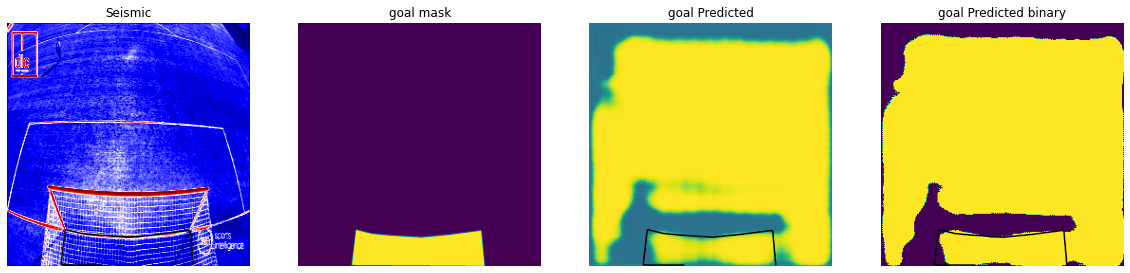

In [22]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


26


C:\Users\viers\AppData\Local\Temp\ipykernel_9624\3448506809.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(20, 10))


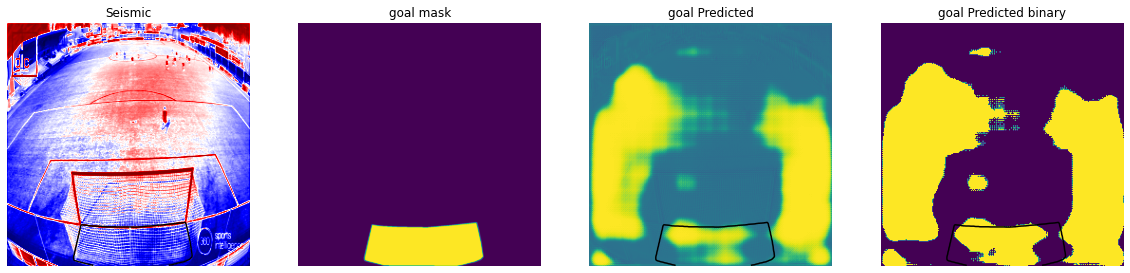

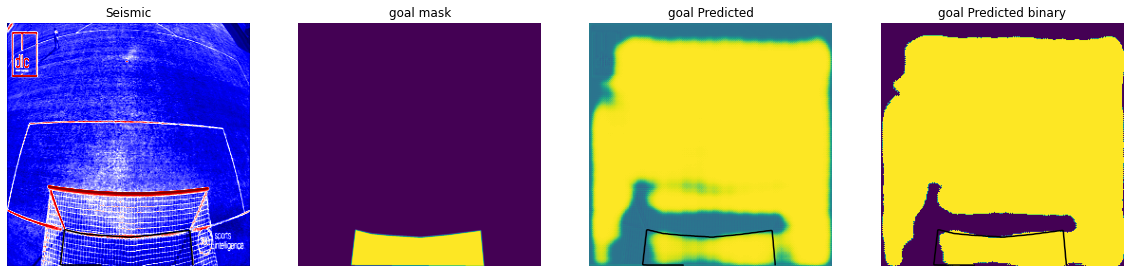

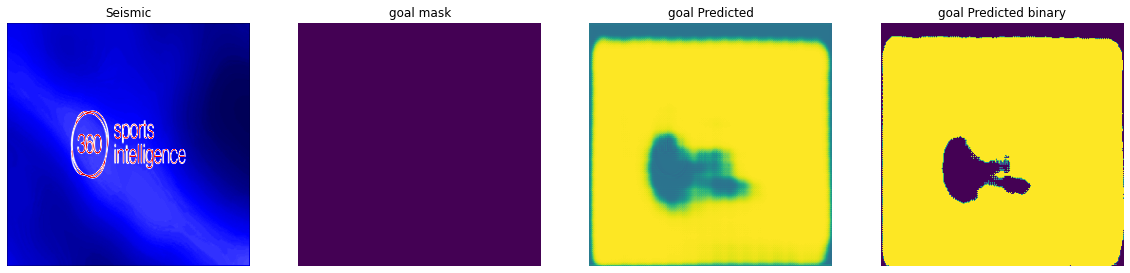

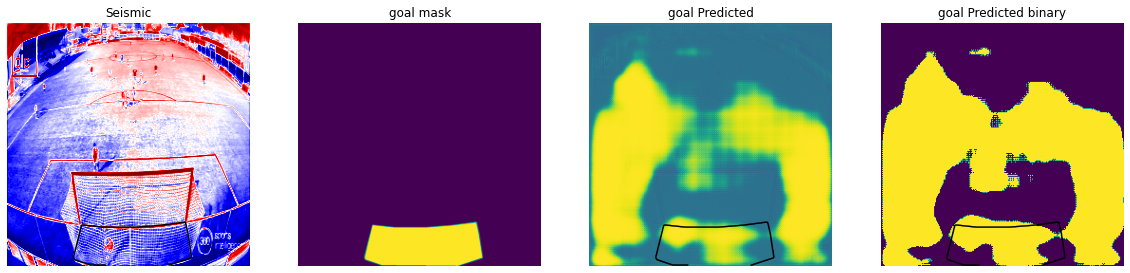

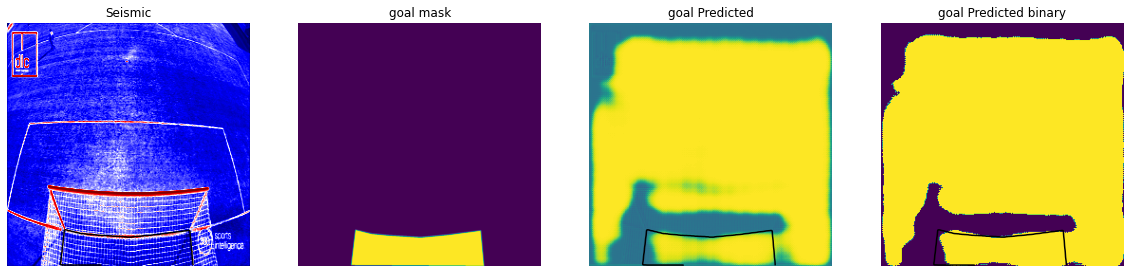

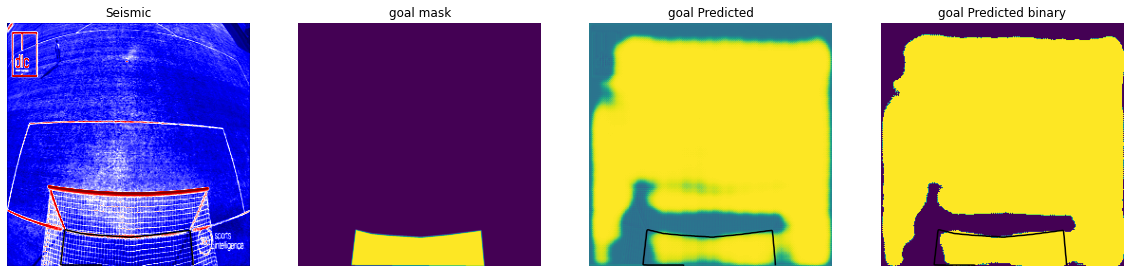

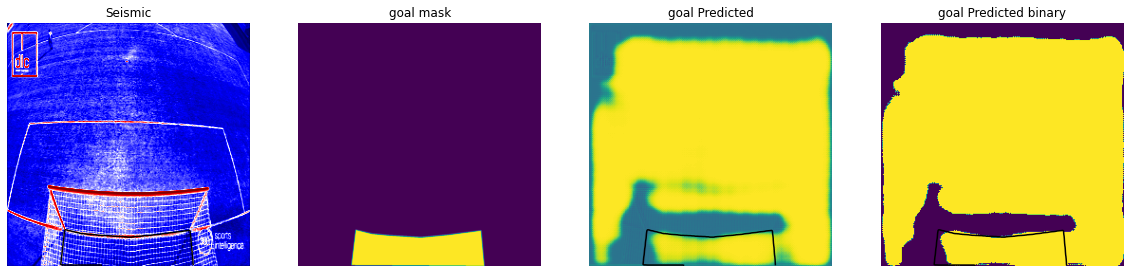

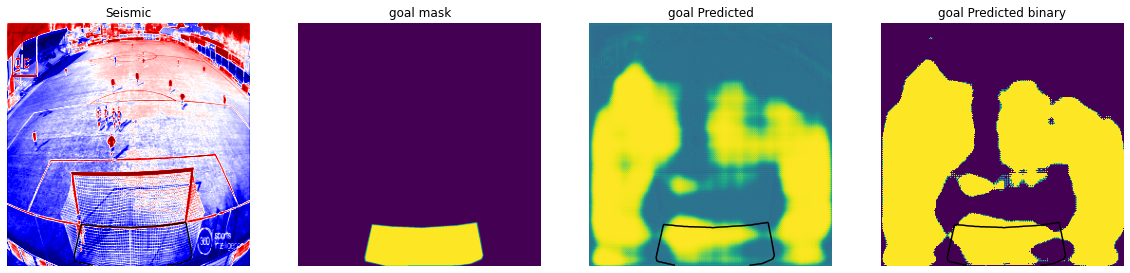

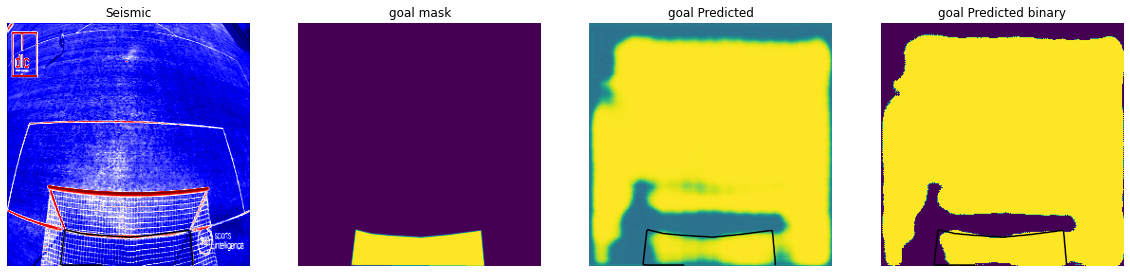

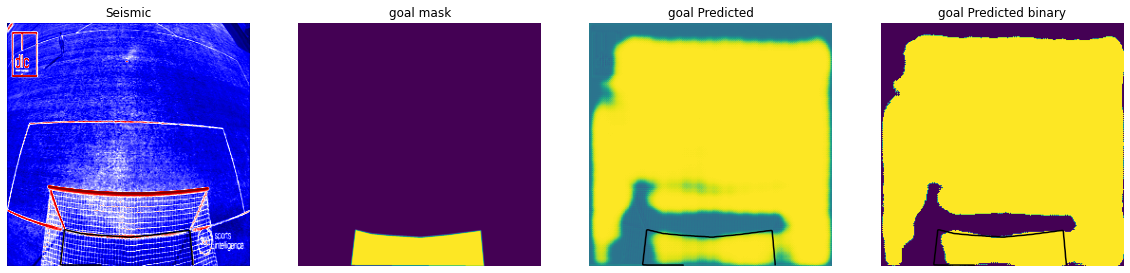

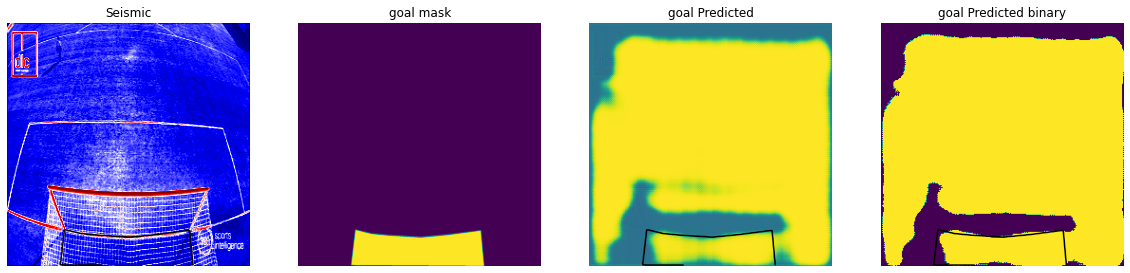

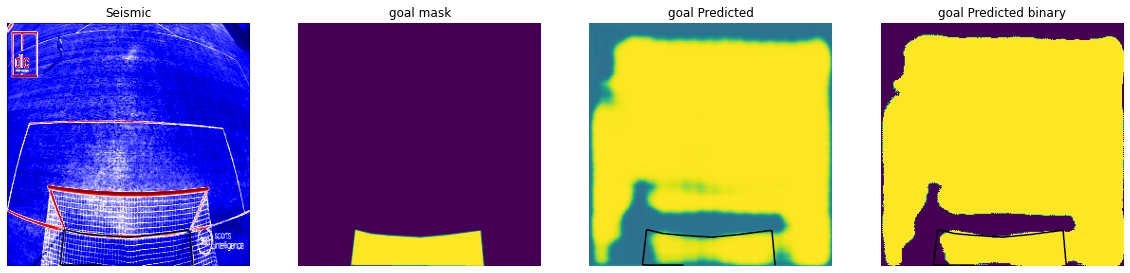

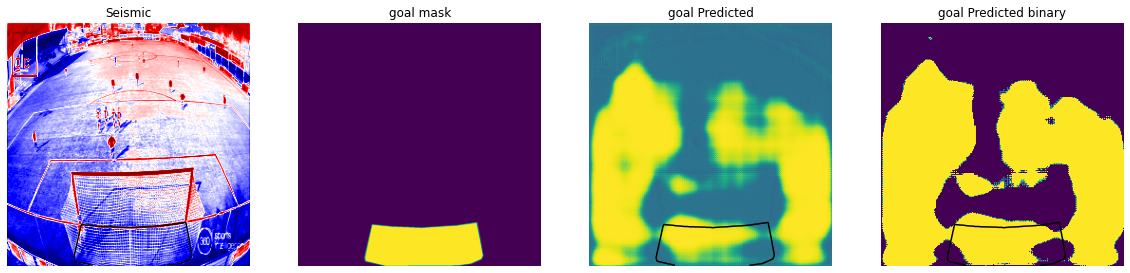

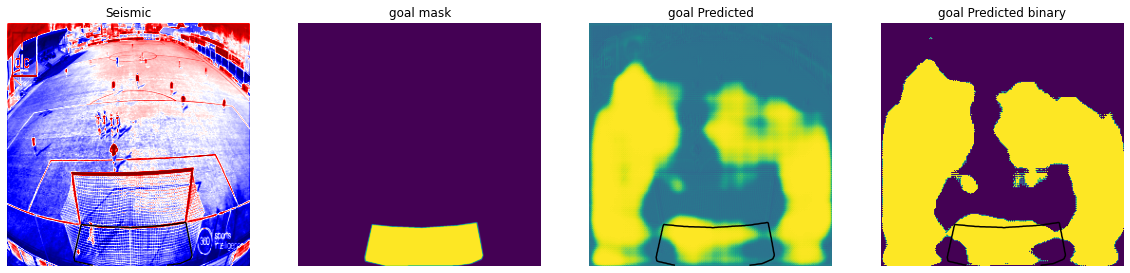

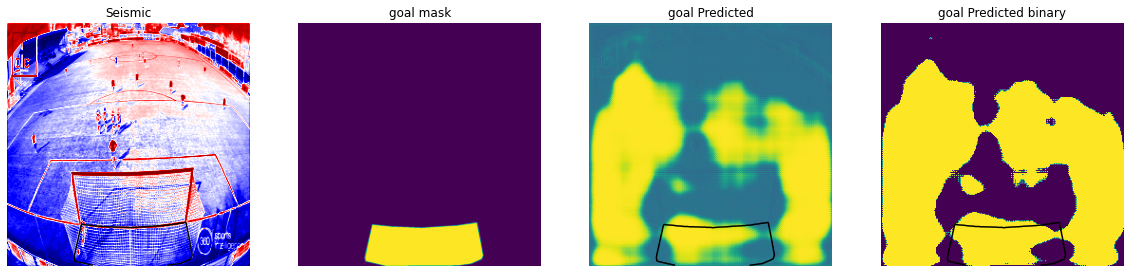

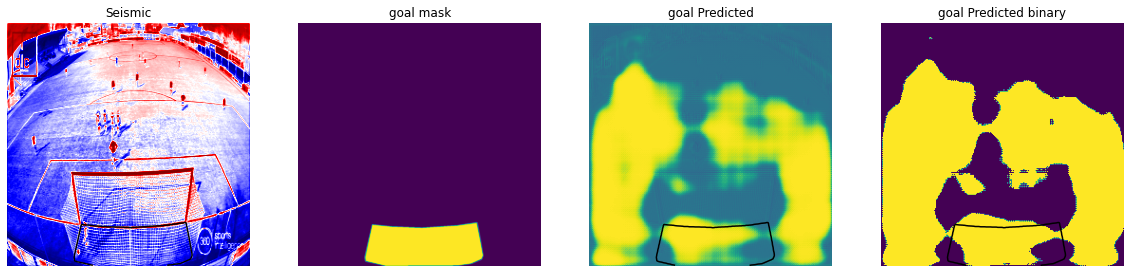

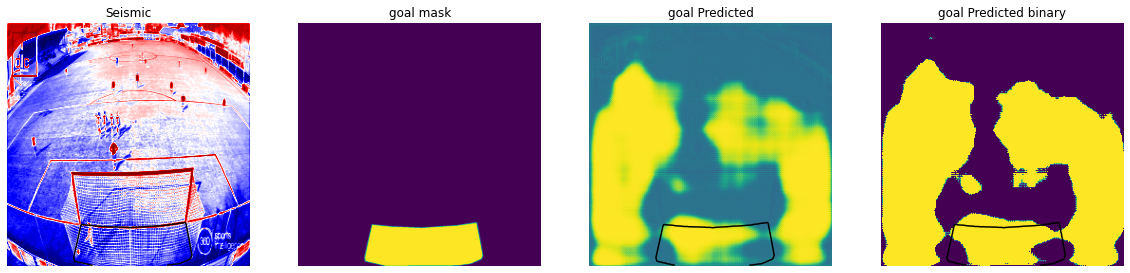

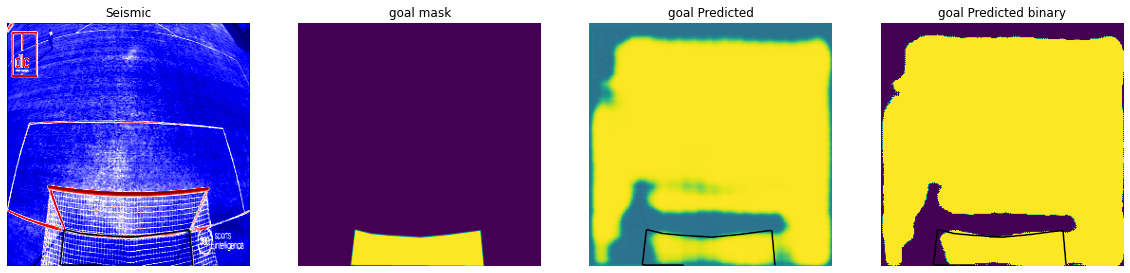

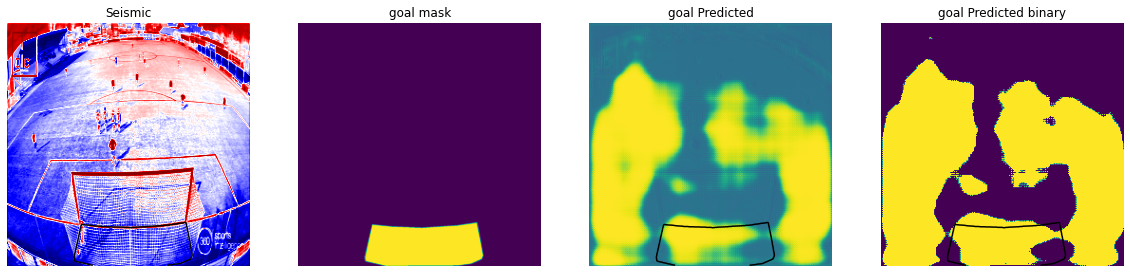

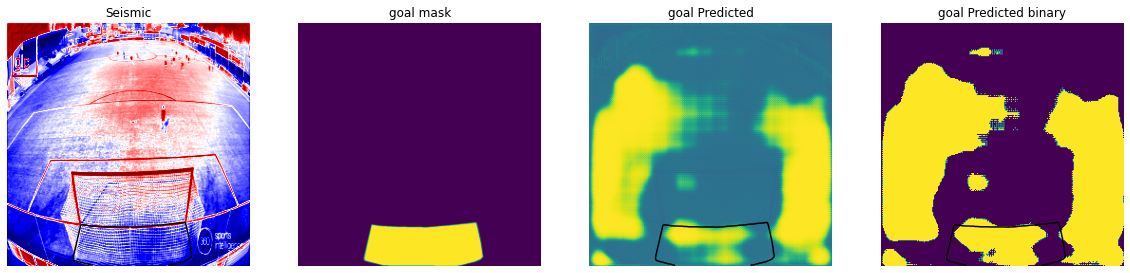

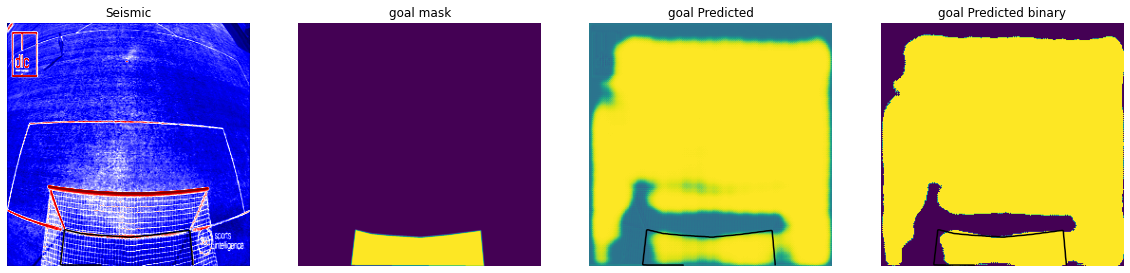

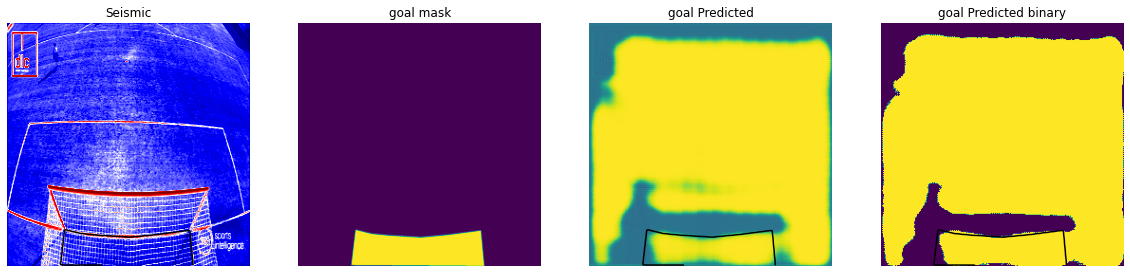

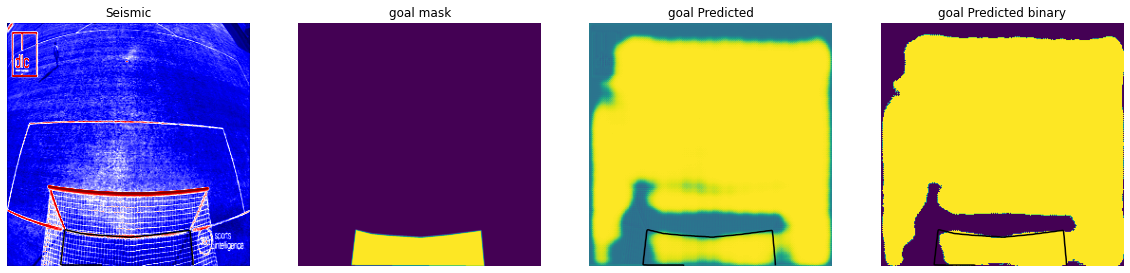

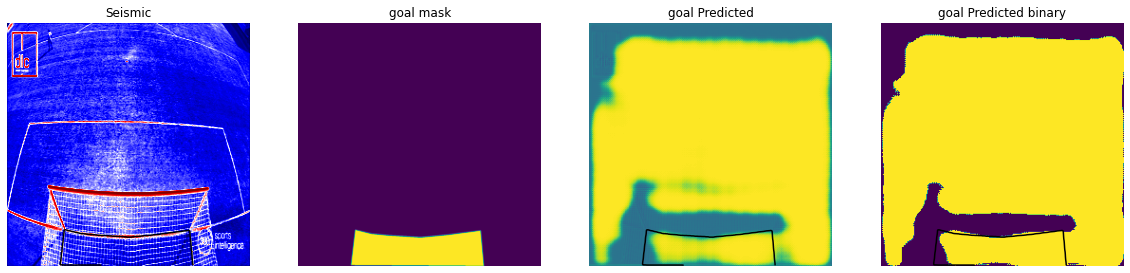

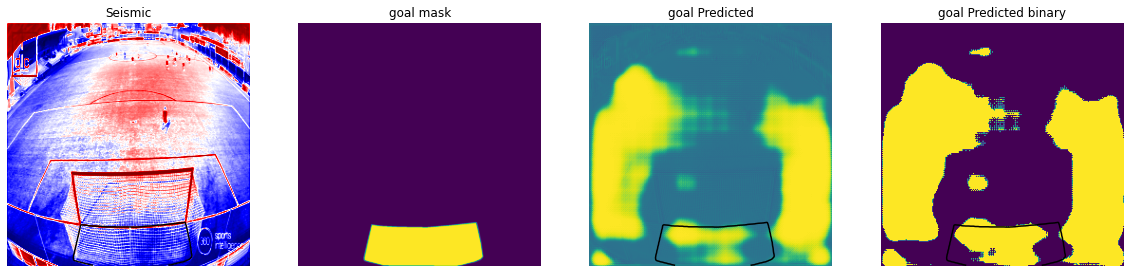

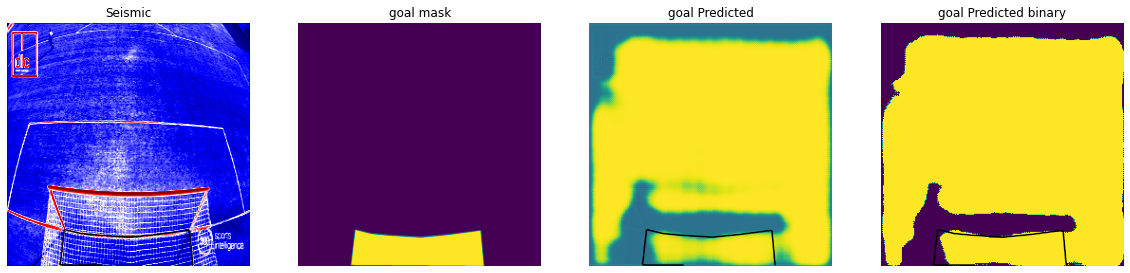

In [23]:
print(len(preds_val_t))
for i in range(0,len(preds_val_t)):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i)

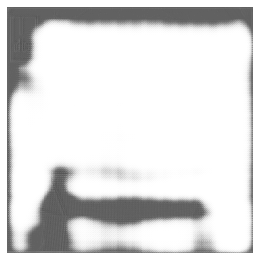

In [24]:
imshow((preds_val[1]))
plt.axis('off')
plt.show()

In [ ]:
import cv2

img = resize(preds_val[1], (1080,1920), mode = 'constant', preserve_range = True)
img = img - img.min() # Now between 0 and 8674
img = img / img.max() * 255
predictedImg = np.uint8(img)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_BGR2GRAY)

imshow(predictedImg)
plt.axis('off')
plt.show()

In [ ]:
ret,predictedImg = cv2.threshold(predictedImg, 100, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(predictedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [ ]:
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
cv2.drawContours(predictedImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(predictedImg)


In [ ]:
print(contours)

In [ ]:
testImg = resize(X_train[7], (1080,1920), mode = 'constant', preserve_range = True)
cv2.drawContours(testImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(testImg)


In [ ]:
pip install shapely

In [ ]:
from shapely.geometry import Point, Polygon
import sys
import numpy
contours = np.squeeze(contours)
numpy.set_printoptions(threshold=sys.maxsize)
print(contours)

In [ ]:
poly = Polygon(contours)

In [ ]:
p1 = Point(1137,963)
p2 = Point(1147,354)
p3 = Point(736,1011)
p4 = Point(729,455)
print(p1.within(poly))
print(p2.within(poly))
print(p3.within(poly))
print(p4.within(poly))


In [ ]:
model.save(r'C:\Users\viers\OneDrive\Bureaublad\MCT\sem4\IndustryProject\IndustryProject\TrainedModels\Unet_Segment_Model_nullTest.h5')